In [1]:
import polars as pl
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
from joblib import Parallel, delayed
from datetime import timedelta, datetime
import time
from tqdm import tqdm
%matplotlib inline

# DRL-specific imports
import gym
import gymnasium as gym  
from gymnasium import spaces  
from stable_baselines3 import PPO, SAC, TD3  
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

PROJECT_DIR = os.path.join(os.getcwd(), "..", "..")

# Global configuration
CONFIG = {
    "batch_size": 128,
    "window_hours": 2,
    "cap_normal": 30,
    "cap_bg": 300,
    "cap_iob": 5,
    "cap_carb": 150,
    "data_path": os.path.join(PROJECT_DIR, "data", "subjects")
}

In [2]:
def get_cgm_window(bolus_time, cgm_df, window_hours=CONFIG["window_hours"]):
    """
    Obtiene una ventana de datos CGM alrededor del tiempo del bolo de insulina.
    
    Args:
        bolus_time (datetime): Tiempo del bolo de insulina
        cgm_df (pl.DataFrame): DataFrame con datos CGM
        window_hours (int): Tamaño de la ventana en horas
    
    Returns:
        np.ndarray: Array numpy con los últimos 24 valores CGM o None si no hay suficientes datos
    """
    window_start = bolus_time - timedelta(hours=window_hours)
    window = cgm_df.filter((pl.col('date') >= window_start) & (pl.col('date') <= bolus_time))
    window = window.sort('date').tail(24)
    return window['mg/dl'].to_numpy() if len(window) >= 24 else None

def calculate_iob(bolus_time, basal_df, half_life_hours=4):
    """
    Calcula la insulina activa (IOB) en un momento dado.
    
    Args:
        bolus_time (datetime): Tiempo para calcular IOB
        basal_df (pl.DataFrame): DataFrame con datos de insulina basal
        half_life_hours (int): Vida media de la insulina en horas
    
    Returns:
        float: Cantidad de insulina activa
    """
    if basal_df is None or len(basal_df) == 0:
        return 0.0
        
    iob = 0
    for row in basal_df.iter_rows(named=True):
        start_time = row['date']
        duration_hours = row['duration'] / (1000 * 3600)
        end_time = start_time + timedelta(hours=duration_hours)
        rate = row['rate'] if row['rate'] is not None else 0.9
        rate = min(rate, 2.0)
        
        if start_time <= bolus_time <= end_time:
            time_since_start = (bolus_time - start_time).total_seconds() / 3600
            remaining = rate * (1 - (time_since_start / half_life_hours))
            iob += max(0, remaining)
            
    return min(iob, 5.0)

def process_subject(subject_path, idx):
    """
    Procesa los datos de un sujeto del estudio.
    
    Args:
        subject_path (str): Ruta al archivo Excel con datos del sujeto
        idx (int): Índice/ID del sujeto
    
    Returns:
        list: Lista de diccionarios con características procesadas
    """
    start_time = time.time()
    
    try:
        # Polars reads Excel files differently than pandas
        cgm_df = pl.read_excel(subject_path, sheet_name="CGM")
        bolus_df = pl.read_excel(subject_path, sheet_name="Bolus")
        try:
            basal_df = pl.read_excel(subject_path, sheet_name="Basal")
        except Exception:
            basal_df = None
    except Exception as e:
        print(f"Error al cargar {os.path.basename(subject_path)}: {e}")
        return []

    # Convert date columns to datetime
    cgm_df = cgm_df.with_columns(pl.col('date').cast(pl.Datetime))
    cgm_df = cgm_df.sort('date')
    bolus_df = bolus_df.with_columns(pl.col('date').cast(pl.Datetime))
    if basal_df is not None:
        basal_df = basal_df.with_columns(pl.col('date').cast(pl.Datetime))

    # Calculate median carb inputs for non-zero values
    non_zero_carbs = bolus_df.filter(pl.col('carbInput') > 0)['carbInput']
    carb_median = non_zero_carbs.median() if len(non_zero_carbs) > 0 else 10.0

    # Calculate IOB values
    iob_values = [calculate_iob(row['date'], basal_df) for row in bolus_df.iter_rows(named=True)]
    non_zero_iob = [iob for iob in iob_values if iob > 0]
    iob_median = np.median(non_zero_iob) if non_zero_iob else 0.5

    processed_data = []
    for row in tqdm(bolus_df.iter_rows(named=True), total=len(bolus_df), 
                   desc=f"Procesando {os.path.basename(subject_path)}", leave=False):
        bolus_time = row['date']
        cgm_window = get_cgm_window(bolus_time, cgm_df)
        
        if cgm_window is not None:
            iob = calculate_iob(bolus_time, basal_df)
            iob = iob_median if iob == 0 else iob
            hour_of_day = bolus_time.hour / 23.0
            bg_input = row['bgInput'] if row['bgInput'] is not None else cgm_window[-1]
            
            normal = row['normal'] if row['normal'] is not None else 0.0
            normal = np.clip(normal, 0, CONFIG["cap_normal"])
            
            bg_input = max(bg_input, 50.0)
            isf_custom = 50.0 if normal <= 0 else (bg_input - 100) / normal
            isf_custom = np.clip(isf_custom, 10, 100)
            
            bg_input = np.clip(bg_input, 0, CONFIG["cap_bg"])
            iob = np.clip(iob, 0, CONFIG["cap_iob"])
            carb_input = row['carbInput'] if row['carbInput'] is not None else 0.0
            carb_input = carb_median if carb_input == 0 else carb_input
            carb_input = np.clip(carb_input, 0, CONFIG["cap_carb"])
            
            features = {
                'subject_id': idx,
                'cgm_window': cgm_window,
                'carbInput': carb_input,
                'bgInput': bg_input,
                'insulinCarbRatio': np.clip(row['insulinCarbRatio'] if row['insulinCarbRatio'] is not None else 10.0, 5, 20),
                'insulinSensitivityFactor': isf_custom,
                'insulinOnBoard': iob,
                'hour_of_day': hour_of_day,
                'normal': normal
            }
            processed_data.append(features)

    elapsed_time = time.time() - start_time
    print(f"Procesado {os.path.basename(subject_path)} (Sujeto {idx+1}) en {elapsed_time:.2f} segundos")
    return processed_data

def process_and_convert_to_polars(all_processed_data):
    """
    Convierte los datos procesados a un DataFrame de Polars.
    
    Args:
        all_processed_data (list): Lista de diccionarios con características procesadas
    
    Returns:
        pl.DataFrame: DataFrame con todos los datos procesados
    """
    # Extraer las ventanas CGM para procesarlas por separado
    cgm_data = [item.pop('cgm_window') for item in all_processed_data]
    
    # Crear el dataframe con los demás datos
    df_processed = pl.DataFrame(all_processed_data)
    
    # Procesar las ventanas CGM y crear columnas individuales
    cgm_columns = [f'cgm_{i}' for i in range(24)]
    cgm_arrays = np.array(cgm_data)
    
    # Crear un dataframe con las columnas CGM
    cgm_df = pl.DataFrame({
        col_name: cgm_arrays[:, i] for i, col_name in enumerate(cgm_columns)
    })
    
    # Unir los dataframes
    return pl.concat([cgm_df, df_processed], how="horizontal")

def preprocess_data(subject_folder):
    """
    Preprocesa los datos de todos los sujetos para el entrenamiento del modelo.
    
    Args:
        subject_folder (str): Ruta a la carpeta que contiene los archivos Excel de los sujetos
        
    Returns:
        pl.DataFrame: DataFrame con todos los datos procesados
    """
    start_time = time.time()
    
    subject_files = [f for f in os.listdir(subject_folder) if f.startswith("Subject") and f.endswith(".xlsx")]
    print(f"\nFound Subject files ({len(subject_files)}):")
    for f in subject_files:
        print(f)

    all_processed_data = Parallel(n_jobs=-1)(delayed(process_subject)(os.path.join(subject_folder, f), idx) 
                                            for idx, f in enumerate(subject_files))
    all_processed_data = [item for sublist in all_processed_data for item in sublist]

    # Convertir a DataFrame de Polars
    df_final = process_and_convert_to_polars(all_processed_data)
    
    print("Muestra de datos procesados combinados:")
    print(df_final.head())
    print(f"Total de muestras: {len(df_final)}")

    # Aplicar transformaciones logarítmicas
    df_final = df_final.with_columns([
        pl.col('normal').map_elements(lambda x: np.log1p(x)).alias('normal'),
        pl.col('carbInput').map_elements(lambda x: np.log1p(x)).alias('carbInput'),
        pl.col('insulinOnBoard').map_elements(lambda x: np.log1p(x)).alias('insulinOnBoard'),
        pl.col('bgInput').map_elements(lambda x: np.log1p(x)).alias('bgInput')
    ])
    
    # Aplicar transformación logarítmica a las columnas CGM
    for col in [f'cgm_{i}' for i in range(24)]:
        df_final = df_final.with_columns(
            pl.col(col).map_elements(lambda x: np.log1p(x)).alias(col)
        )
    
    # Eliminar filas con valores nulos
    df_final = df_final.drop_nulls()
    print("Verificación de NaN en df_final:")
    print(df_final.null_count())

    elapsed_time = time.time() - start_time
    print(f"Preprocesamiento completo en {elapsed_time:.2f} segundos")
    return df_final

def split_data(df_final):
    """
    Divide los datos en conjuntos de entrenamiento, validación y prueba, asegurando distribuciones similares.
    Fuerza al Sujeto 49 a estar en el conjunto de prueba para evaluación y equilibra medias y desviaciones estándar.
    
    Args:
        df_final (pl.DataFrame): DataFrame con todos los datos
        
    Returns:
        tuple: Tupla con datos divididos para entrenamiento, validación y prueba
    """
    start_time = time.time()
    
    # Convertir a pandas para algunas operaciones específicas
    df_final_pd = df_final.to_pandas()
    
    # Compute the mean and std insulin dose for each subject
    subject_stats = df_final_pd.groupby('subject_id')['normal'].agg(['mean', 'std']).reset_index()
    subject_stats.columns = ['subject_id', 'mean_dose', 'std_dose']
    subject_ids = df_final_pd['subject_id'].unique()

    # Sort subjects by their mean insulin dose
    sorted_subjects = subject_stats.sort_values('mean_dose')['subject_id'].values
    n_subjects = len(sorted_subjects)

    # Aim for 80%-10%-10% split
    train_size = int(0.8 * n_subjects)  # 80% for training
    val_size = int(0.1 * n_subjects)    # 10% for validation
    test_size = n_subjects - train_size - val_size  # 10% for test

    # Force Subject 49 into the test set
    test_subjects = [49] if 49 in sorted_subjects else []
    remaining_subjects = [s for s in sorted_subjects if s != 49]
    train_subjects = []
    val_subjects = []

    # Initialize lists and track stats
    train_subjects = []
    val_subjects = []
    test_subjects = [49] if 49 in sorted_subjects else []

    # Assign subjects to minimize differences in means and stds
    remaining_subjects_list = list(remaining_subjects)
    np.random.shuffle(remaining_subjects_list)  # Shuffle to avoid bias in assignment order

    for i, subject in enumerate(remaining_subjects_list):
        # Compute current means and stds of each set
        train_mean = df_final_pd[df_final_pd['subject_id'].isin(train_subjects)]['normal'].mean() if train_subjects else 0
        val_mean = df_final_pd[df_final_pd['subject_id'].isin(val_subjects)]['normal'].mean() if val_subjects else 0
        test_mean = df_final_pd[df_final_pd['subject_id'].isin(test_subjects)]['normal'].mean() if test_subjects else 0
        train_std = df_final_pd[df_final_pd['subject_id'].isin(train_subjects)]['normal'].std() if train_subjects else 0
        val_std = df_final_pd[df_final_pd['subject_id'].isin(val_subjects)]['normal'].std() if val_subjects else 0
        test_std = df_final_pd[df_final_pd['subject_id'].isin(test_subjects)]['normal'].std() if test_subjects else 0

        # Compute the stats if we add this subject to each set
        train_temp = train_subjects + [subject]
        val_temp = val_subjects + [subject]
        test_temp = test_subjects + [subject]

        train_mean_new = df_final_pd[df_final_pd['subject_id'].isin(train_temp)]['normal'].mean()
        val_mean_new = df_final_pd[df_final_pd['subject_id'].isin(val_temp)]['normal'].mean()
        test_mean_new = df_final_pd[df_final_pd['subject_id'].isin(test_temp)]['normal'].mean()
        train_std_new = df_final_pd[df_final_pd['subject_id'].isin(train_temp)]['normal'].std()
        val_std_new = df_final_pd[df_final_pd['subject_id'].isin(val_temp)]['normal'].std()
        test_std_new = df_final_pd[df_final_pd['subject_id'].isin(test_temp)]['normal'].std()

        # Compute the mean and std differences if we add to each set
        means_if_train = [train_mean_new, val_mean, test_mean]
        means_if_val = [train_mean, val_mean_new, test_mean]
        means_if_test = [train_mean, val_mean, test_mean_new]
        stds_if_train = [train_std_new, val_std, test_std]
        stds_if_val = [train_std, val_std_new, test_std]
        stds_if_test = [train_std, val_std, test_std_new]

        # Compute the range of means and stds (max - min) for each option
        range_means_if_train = max(means_if_train) - min(means_if_train) if all(m != 0 for m in means_if_train) else float('inf')
        range_means_if_val = max(means_if_val) - min(means_if_val) if all(m != 0 for m in means_if_val) else float('inf')
        range_means_if_test = max(means_if_test) - min(means_if_test) if all(m != 0 for m in means_if_test) else float('inf')
        range_stds_if_train = max(stds_if_train) - min(stds_if_train) if all(s != 0 for s in stds_if_train) else float('inf')
        range_stds_if_val = max(stds_if_val) - min(stds_if_val) if all(s != 0 for s in stds_if_val) else float('inf')
        range_stds_if_test = max(stds_if_test) - min(stds_if_test) if all(s != 0 for s in stds_if_test) else float('inf')

        # Combine mean and std differences (weighted equally)
        score_if_train = range_means_if_train + range_stds_if_train
        score_if_val = range_means_if_val + range_stds_if_val
        score_if_test = range_means_if_test + range_stds_if_test

        # Respect the target split sizes
        if len(train_subjects) < train_size and score_if_train <= min(score_if_val, score_if_test):
            train_subjects.append(subject)
        elif len(val_subjects) < val_size and score_if_val <= min(score_if_train, score_if_test):
            val_subjects.append(subject)
        elif len(test_subjects) < test_size:
            test_subjects.append(subject)
        else:
            # If sizes are exceeded, default to train
            train_subjects.append(subject)

    # Create masks for splitting
    train_mask = df_final_pd['subject_id'].isin(train_subjects)
    val_mask = df_final_pd['subject_id'].isin(val_subjects)
    test_mask = df_final_pd['subject_id'].isin(test_subjects)

    # Check distributions after splitting
    y_train_temp = df_final_pd.loc[train_mask, 'normal']
    y_val_temp = df_final_pd.loc[val_mask, 'normal']
    y_test_temp = df_final_pd.loc[test_mask, 'normal']
    print("Post-split Train y: mean =", y_train_temp.mean(), "std =", y_train_temp.std())
    print("Post-split Val y: mean =", y_val_temp.mean(), "std =", y_val_temp.std())
    print("Post-split Test y: mean =", y_test_temp.mean(), "std =", y_test_temp.std())

    # Initialize scalers
    scaler_cgm = StandardScaler()
    scaler_other = StandardScaler()
    scaler_y = StandardScaler()
    cgm_columns = [f'cgm_{i}' for i in range(24)]
    other_features = ['carbInput', 'bgInput', 'insulinOnBoard', 'insulinCarbRatio', 
                      'insulinSensitivityFactor', 'hour_of_day']

    # Scale only on training data
    X_cgm_train = scaler_cgm.fit_transform(df_final_pd.loc[train_mask, cgm_columns]).reshape(-1, 24, 1)
    X_cgm_val = scaler_cgm.transform(df_final_pd.loc[val_mask, cgm_columns]).reshape(-1, 24, 1)
    X_cgm_test = scaler_cgm.transform(df_final_pd.loc[test_mask, cgm_columns]).reshape(-1, 24, 1)
    
    X_other_train = scaler_other.fit_transform(df_final_pd.loc[train_mask, other_features])
    X_other_val = scaler_other.transform(df_final_pd.loc[val_mask, other_features])
    X_other_test = scaler_other.transform(df_final_pd.loc[test_mask, other_features])
    
    y_train = scaler_y.fit_transform(df_final_pd.loc[train_mask, 'normal'].values.reshape(-1, 1)).flatten()
    y_val = scaler_y.transform(df_final_pd.loc[val_mask, 'normal'].values.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(df_final_pd.loc[test_mask, 'normal'].values.reshape(-1, 1)).flatten()

    X_subject_train = df_final_pd.loc[train_mask, 'subject_id'].values
    X_subject_val = df_final_pd.loc[val_mask, 'subject_id'].values
    X_subject_test = df_final_pd.loc[test_mask, 'subject_id'].values
    subject_test = X_subject_test

    print(f"Entrenamiento CGM: {X_cgm_train.shape}, Validación CGM: {X_cgm_val.shape}, Prueba CGM: {X_cgm_test.shape}")
    print(f"Entrenamiento Otros: {X_other_train.shape}, Validación Otros: {X_other_val.shape}, Prueba Otros: {X_other_test.shape}")
    print(f"Entrenamiento Subject: {X_subject_train.shape}, Validación Subject: {X_subject_val.shape}, Prueba Subject: {X_subject_test.shape}")
    print(f"Sujetos de prueba: {test_subjects}")

    elapsed_time = time.time() - start_time
    print(f"División de datos completa en {elapsed_time:.2f} segundos")
    return (X_cgm_train, X_cgm_val, X_cgm_test,
            X_other_train, X_other_val, X_other_test,
            X_subject_train, X_subject_val, X_subject_test,
            y_train, y_val, y_test, subject_test,
            scaler_cgm, scaler_other, scaler_y)

def rule_based_prediction(X_other, scaler_other, scaler_y, target_bg=100):
    """
    Genera predicciones basadas en reglas médicas estándar.
    
    Args:
        X_other (np.ndarray): Características adicionales normalizadas
        scaler_other (StandardScaler): Scaler para desnormalizar características
        scaler_y (StandardScaler): Scaler para normalizar predicciones
        target_bg (int): Nivel objetivo de glucosa en sangre
        
    Returns:
        np.ndarray: Array con predicciones de dosis
    """
    start_time = time.time()
    
    X_other_np = X_other
    inverse_transformed = scaler_other.inverse_transform(X_other_np)
    carb_input, bg_input, icr, isf = (inverse_transformed[:, 0],
                                     inverse_transformed[:, 1],
                                     inverse_transformed[:, 3],
                                     inverse_transformed[:, 4])
    
    icr = np.where(icr == 0, 1e-6, icr)
    isf = np.where(isf == 0, 1e-6, isf)
    
    carb_component = np.divide(carb_input, icr, out=np.zeros_like(carb_input), where=icr!=0)
    bg_component = np.divide(bg_input - target_bg, isf, out=np.zeros_like(bg_input), where=isf!=0)
    
    prediction = carb_component + bg_component
    prediction = np.clip(prediction, 0, CONFIG["cap_normal"])

    elapsed_time = time.time() - start_time
    print(f"Predicción basada en reglas completa en {elapsed_time:.2f} segundos")
    return prediction

In [3]:
def compute_metrics(y_true, y_pred, scaler_y):
    """
    Calcula métricas de evaluación para las predicciones.
    
    Args:
        y_true (np.ndarray): Valores verdaderos normalizados
        y_pred (np.ndarray): Valores predichos desnormalizados
        scaler_y (StandardScaler): Scaler para desnormalizar valores verdaderos
        
    Returns:
        tuple: Tupla con MAE, RMSE y R²
    """
    y_true_denorm = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_denorm = y_pred  # Already denormalized
    mae = mean_absolute_error(y_true_denorm, y_pred_denorm)
    rmse = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))
    r2 = r2_score(y_true_denorm, y_pred_denorm)
    return mae, rmse, r2

def plot_evaluation(y_test, y_pred_ppo, y_rule, subject_test, scaler_y):
    """
    Visualiza los resultados de evaluación mediante gráficos.
    
    Args:
        y_test (np.ndarray): Valores verdaderos normalizados
        y_pred_ppo (np.ndarray): Predicciones del modelo PPO desnormalizadas
        y_rule (np.ndarray): Predicciones del modelo basado en reglas desnormalizadas
        subject_test (np.ndarray): IDs de los sujetos de prueba
        scaler_y (StandardScaler): Scaler para desnormalizar valores verdaderos
    """
    start_time = time.time()
    y_test_denorm = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

    colors = {'PPO': 'green', 'Rules': 'orange'}
    offset = 1e-2

    # 1. Predictions vs Real (Density Scatter Plot for PPO)
    plt.figure(figsize=(8, 6))
    sns.kdeplot(x=y_test_denorm + offset, y=y_pred_ppo + offset, cmap="viridis", fill=True, levels=5, thresh=.05)
    plt.plot([offset, 15], [offset, 15], 'k--', label='Perfect Prediction')
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks([0.01, 0.1, 1, 10, 15], ['0.01', '0.1', '1', '10', '15'])
    plt.yticks([0.01, 0.1, 1, 10, 15], ['0.01', '0.1', '1', '10', '15'])
    plt.xlabel('Real Dose (units)', fontsize=10)
    plt.ylabel('Predicted Dose (units)', fontsize=10)
    plt.title('PPO: Predictions vs Real (Density)', fontsize=12)
    plt.legend()
    plt.show()

    # 2. Residual Distribution (KDE Plots)
    plt.figure(figsize=(10, 6))
    residuals_ppo = y_test_denorm - y_pred_ppo
    residuals_rule = y_test_denorm - y_rule

    sns.kdeplot(residuals_ppo, label='PPO', color=colors['PPO'], fill=True, alpha=0.3)
    sns.kdeplot(residuals_rule, label='Rules', color=colors['Rules'], fill=True, alpha=0.3)
    plt.xlabel('Residual (units)', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.title('Residual Distribution (KDE)', fontsize=12)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.show()

    # 3. MAE by Subject
    plt.figure(figsize=(10, 6))
    test_subjects = np.unique(subject_test)
    mae_ppo, mae_rule = [], []
    for sid in test_subjects:
        mask = subject_test == sid
        if np.sum(mask) > 0:
            mae_ppo.append(mean_absolute_error(y_test_denorm[mask], y_pred_ppo[mask]))
            mae_rule.append(mean_absolute_error(y_test_denorm[mask], y_rule[mask]))

    bar_width = 0.35
    x = np.arange(len(test_subjects))
    plt.bar(x - bar_width/2, mae_ppo, width=bar_width, label='PPO', color=colors['PPO'], alpha=0.8)
    plt.bar(x + bar_width/2, mae_rule, width=bar_width, label='Rules', color=colors['Rules'], alpha=0.8)
    plt.xlabel('Subject', fontsize=10)
    plt.ylabel('MAE (units)', fontsize=10)
    plt.xticks(x, test_subjects, rotation=45, ha='right', fontsize=8)
    plt.ylim(0, 2.5)  # Adjusted to accommodate Rules MAE
    plt.title('MAE by Subject', fontsize=12)
    plt.legend(fontsize=8)
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

    elapsed_time = time.time() - start_time
    print(f"Visualización completa en {elapsed_time:.2f} segundos")

In [4]:
class InsulinDoseEnv(gym.Env):
    """
    Entorno de aprendizaje por refuerzo para predecir dosis de insulina.
    
    Attributes:
        X_cgm (np.ndarray): Datos CGM normalizados
        X_other (np.ndarray): Otras características normalizadas
        y (np.ndarray): Valores objetivo normalizados
        scaler_y (StandardScaler): Scaler para desnormalizar dosis
        current_step (int): Paso actual en el entorno
        n_samples (int): Número total de muestras
        observation_space (spaces.Box): Espacio de observación
        action_space (spaces.Box): Espacio de acción
    """
    
    def __init__(self, X_cgm, X_other, y, scaler_y):
        """
        Inicializa el entorno de aprendizaje por refuerzo.
        
        Args:
            X_cgm (np.ndarray): Datos CGM normalizados
            X_other (np.ndarray): Otras características normalizadas
            y (np.ndarray): Valores objetivo normalizados
            scaler_y (StandardScaler): Scaler para desnormalizar dosis
        """
        super(InsulinDoseEnv, self).__init__()
        self.X_cgm = X_cgm.astype(np.float32)  # Ensure input data is float32
        self.X_other = X_other.astype(np.float32)  # Ensure input data is float32
        self.y = y.astype(np.float32)  # Ensure target data is float32
        self.scaler_y = scaler_y  # Scaler for denormalizing doses
        self.current_step = 0
        self.n_samples = len(X_cgm)
        
        # Define the state space (CGM + other features)
        state_dim = X_cgm.shape[2] * X_cgm.shape[1] + X_other.shape[1]  # Flatten CGM (24*1) + other features (6)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(state_dim,), dtype=np.float32)
        
        # Define the action space (insulin dose, continuous)
        self.action_space = spaces.Box(low=-3, high=3, shape=(1,), dtype=np.float32)  # Adjust based on your scaler
        
    def reset(self, seed=None, options=None):
        """
        Reinicia el entorno a un estado inicial aleatorio.
        
        Args:
            seed (int, optional): Semilla para generación aleatoria
            options (dict, optional): Opciones adicionales
            
        Returns:
            tuple: Estado inicial y diccionario de información
        """
        super().reset(seed=seed)
        self.current_step = np.random.randint(0, self.n_samples)
        cgm_state = self.X_cgm[self.current_step].flatten()  # Shape: (24,)
        other_state = self.X_other[self.current_step]  # Shape: (6,)
        state = np.concatenate([cgm_state, other_state]).astype(np.float32)  # Ensure state is float32
        self.current_state = state  # Store the current state for use in step()
        return state, {}  # Return state and info dict
    
    def step(self, action):
        """
        Ejecuta un paso en el entorno con la acción dada.
        
        Args:
            action (np.ndarray): Acción a ejecutar (dosis de insulina)
            
        Returns:
            tuple: Próximo estado, recompensa, finalizado, truncado, información
        """
        true_dose = self.scaler_y.inverse_transform(self.y[self.current_step].reshape(-1, 1)).flatten()[0]
        predicted_dose = self.scaler_y.inverse_transform(action.reshape(-1, 1)).flatten()[0]
        error = predicted_dose - true_dose
        weight = 1.0 + (true_dose / 3.0)  # Slightly more aggressive weighting
        reward = -min(abs(error), 2.0) * weight  # Apply weight to clipped absolute error
        reward = float(reward)
        done = True
        truncated = False
        info = {"true_dose": true_dose, "predicted_dose": predicted_dose}
        next_state = self.current_state
        return next_state, reward, done, truncated, info
    
    def render(self, mode='human'):
        """
        Muestra visualmente el entorno (no implementado).
        
        Args:
            mode (str): Modo de visualización
        """
        pass

class RewardCallback(BaseCallback):
    """
    Callback para seguimiento de recompensas durante el entrenamiento.
    
    Attributes:
        train_rewards (list): Lista de recompensas de entrenamiento
        val_rewards (list): Lista de recompensas de validación
        val_env (InsulinDoseEnv): Entorno de validación
    """
    
    def __init__(self, val_env, verbose=0):
        """
        Inicializa el callback.
        
        Args:
            val_env (InsulinDoseEnv): Entorno de validación
            verbose (int): Nivel de verbosidad
        """
        super().__init__(verbose)
        self.train_rewards = []
        self.val_rewards = []
        self.val_env = val_env

    def _on_step(self):
        """
        Se ejecuta en cada paso del entrenamiento.
        
        Returns:
            bool: Si continuar el entrenamiento
        """
        self.train_rewards.append(self.locals['rewards'][0])
        # Evaluate on validation set every 1000 steps
        if self.num_timesteps % 1000 == 0:
            val_reward = self.evaluate_val()
            self.val_rewards.append(val_reward)
        return True

    def evaluate_val(self):
        """
        Evalúa el modelo actual en el conjunto de validación.
        
        Returns:
            float: Recompensa promedio en validación
        """
        total_reward = 0
        for _ in range(10):  # Evaluate on 10 random validation samples
            state, _ = self.val_env.reset()
            action, _ = self.model.predict(state, deterministic=True)
            _, reward, _, _, _ = self.val_env.step(action)
            total_reward += reward
        return total_reward / 10

In [5]:
df_final = preprocess_data(CONFIG["data_path"])
#Save the df_final in a csv
df_final.write_csv('df_final.csv')


Found Subject files (54):
Subject21.xlsx
Subject37.xlsx
Subject17.xlsx
Subject40.xlsx
Subject6.xlsx
Subject7.xlsx
Subject41.xlsx
Subject16.xlsx
Subject36.xlsx
Subject20.xlsx
Subject11.xlsx
Subject46.xlsx
Subject50.xlsx
Subject27.xlsx
Subject31.xlsx
Subject30.xlsx
Subject26.xlsx
Subject1.xlsx
Subject51.xlsx
Subject47.xlsx
Subject10.xlsx
Subject29.xlsx
Subject2.xlsx
Subject52.xlsx
Subject44.xlsx
Subject13.xlsx
Subject33.xlsx
Subject25.xlsx
Subject48.xlsx
Subject49.xlsx
Subject24.xlsx
Subject32.xlsx
Subject12.xlsx
Subject45.xlsx
Subject53.xlsx
Subject3.xlsx
Subject28.xlsx
Subject35.xlsx
Subject23.xlsx
Subject8.xlsx
Subject19.xlsx
Subject39.xlsx
Subject4.xlsx
Subject54.xlsx
Subject42.xlsx
Subject15.xlsx
Subject14.xlsx
Subject43.xlsx
Subject5.xlsx
Subject38.xlsx
Subject18.xlsx
Subject9.xlsx
Subject22.xlsx
Subject34.xlsx


Procesando Subject41.xlsx:  50%|█████     | 466/930 [00:00<00:00, 1792.38it/s]]

Procesado Subject21.xlsx (Sujeto 1) en 1.08 segundos
Procesado Subject17.xlsx (Sujeto 3) en 0.78 segundos
Procesado Subject40.xlsx (Sujeto 4) en 0.86 segundos
Procesado Subject50.xlsx (Sujeto 13) en 0.13 segundos
Procesado Subject41.xlsx (Sujeto 7) en 0.58 segundos


Procesado Subject27.xlsx (Sujeto 14) en 0.55 segundos
Procesado Subject16.xlsx (Sujeto 8) en 1.27 segundos


Procesando Subject7.xlsx:  57%|█████▋    | 1046/1825 [00:00<00:00, 1585.15it/s]]

Procesado Subject46.xlsx (Sujeto 12) en 1.03 segundos
Procesado Subject26.xlsx (Sujeto 17) en 0.34 segundos


Procesando Subject37.xlsx:  25%|██▌       | 142/559 [00:00<00:01, 253.28it/s]s] 

Procesado Subject6.xlsx (Sujeto 5) en 2.13 segundos
Procesado Subject11.xlsx (Sujeto 11) en 1.72 segundos
Procesado Subject20.xlsx (Sujeto 10) en 1.76 segundos
Procesado Subject7.xlsx (Sujeto 6) en 2.23 segundos


Procesando Subject44.xlsx:   0%|          | 0/813 [00:00<?, ?it/s]             

Procesado Subject52.xlsx (Sujeto 24) en 0.33 segundos


Procesando Subject44.xlsx:  42%|████▏     | 340/813 [00:00<00:00, 1386.66it/s]Could not determine dtype for column 5, falling back to string


Procesado Subject10.xlsx (Sujeto 21) en 0.85 segundos
Procesado Subject44.xlsx (Sujeto 25) en 0.45 segundos
Procesado Subject1.xlsx (Sujeto 18) en 1.54 segundos


Procesado Subject33.xlsx (Sujeto 27) en 0.55 segundos
Procesado Subject2.xlsx (Sujeto 23) en 1.57 segundos
Procesado Subject37.xlsx (Sujeto 2) en 3.93 segundos


Procesando Subject25.xlsx:  78%|███████▊  | 1183/1517 [00:00<00:00, 2354.52it/s]

Procesado Subject48.xlsx (Sujeto 29) en 0.23 segundos
Procesado Subject25.xlsx (Sujeto 28) en 0.91 segundos


Procesando Subject24.xlsx:  26%|██▌       | 451/1737 [00:00<00:00, 4509.13it/s] 

Procesado Subject32.xlsx (Sujeto 32) en 0.21 segundos
Procesado Subject13.xlsx (Sujeto 26) en 1.13 segundos


Procesando Subject30.xlsx:  18%|█▊        | 167/927 [00:00<00:03, 216.24it/s]   

Procesado Subject24.xlsx (Sujeto 31) en 0.70 segundos


Procesado Subject49.xlsx (Sujeto 30) en 1.04 segundos
Procesado Subject53.xlsx (Sujeto 35) en 0.75 segundos


Procesando Subject28.xlsx:  90%|█████████ | 1352/1501 [00:00<00:00, 2865.10it/s]

Procesado Subject12.xlsx (Sujeto 33) en 1.21 segundos
Procesado Subject3.xlsx (Sujeto 36) en 0.85 segundos
Procesado Subject35.xlsx (Sujeto 38) en 0.50 segundos


Procesando Subject51.xlsx:  44%|████▍     | 145/328 [00:01<00:01, 124.15it/s]]  

Procesado Subject28.xlsx (Sujeto 37) en 0.75 segundos


Procesando Subject31.xlsx:   1%|▏         | 23/1595 [00:00<00:06, 226.26it/s]s]

Procesado Subject23.xlsx (Sujeto 39) en 0.46 segundos


Procesando Subject31.xlsx:   8%|▊         | 120/1595 [00:00<00:06, 227.84it/s]  

Procesado Subject8.xlsx (Sujeto 40) en 0.71 segundos
Procesado Subject19.xlsx (Sujeto 41) en 0.71 segundos


Procesando Subject54.xlsx:  64%|██████▎   | 84/132 [00:00<00:00, 194.28it/s] ]]

Procesado Subject51.xlsx (Sujeto 19) en 5.39 segundos


Procesando Subject29.xlsx:  67%|██████▋   | 774/1153 [00:01<00:00, 560.05it/s]]

Procesado Subject54.xlsx (Sujeto 44) en 1.21 segundos


Procesado Subject15.xlsx (Sujeto 46) en 0.47 segundos
Procesado Subject30.xlsx (Sujeto 16) en 6.87 segundos


Procesando Subject4.xlsx:  98%|█████████▊| 3672/3751 [00:01<00:00, 1542.58it/s]

Procesado Subject29.xlsx (Sujeto 22) en 5.89 segundos
Procesado Subject43.xlsx (Sujeto 48) en 0.46 segundos
Procesado Subject47.xlsx (Sujeto 20) en 6.44 segundos
Procesado Subject4.xlsx (Sujeto 43) en 2.43 segundos


Procesando Subject22.xlsx:   0%|          | 0/252 [00:00<?, ?it/s]              

Procesado Subject14.xlsx (Sujeto 47) en 1.03 segundos
Procesado Subject22.xlsx (Sujeto 53) en 0.29 segundos


Procesado Subject18.xlsx (Sujeto 51) en 0.58 segundos
Procesado Subject34.xlsx (Sujeto 54) en 0.35 segundos


Procesando Subject5.xlsx:  61%|██████    | 3022/4967 [00:00<00:00, 4957.56it/s]

Procesado Subject9.xlsx (Sujeto 52) en 0.88 segundos


Procesando Subject36.xlsx:   0%|          | 0/507 [00:00<?, ?it/s]             

Procesado Subject5.xlsx (Sujeto 49) en 1.82 segundos


Procesando Subject36.xlsx:  35%|███▍      | 176/507 [00:02<00:05, 65.76it/s]   

Procesado Subject31.xlsx (Sujeto 15) en 10.97 segundos


Procesando Subject42.xlsx:  40%|████      | 206/509 [00:02<00:04, 66.47it/s] 

Procesado Subject36.xlsx (Sujeto 9) en 16.13 segundos


Procesando Subject45.xlsx:  73%|███████▎  | 569/783 [00:06<00:01, 121.71it/s]

Procesado Subject42.xlsx (Sujeto 45) en 14.03 segundos


Procesando Subject45.xlsx:  84%|████████▍ | 657/783 [00:06<00:01, 102.95it/s]

Procesado Subject39.xlsx (Sujeto 42) en 15.52 segundos


Procesando Subject38.xlsx:  48%|████▊     | 333/696 [00:03<00:04, 85.26it/s] 

Procesado Subject45.xlsx (Sujeto 34) en 18.16 segundos


/var/folders/b9/dh9qy_tj6p7g8mrkr5cj9rmc0000gn/T/ipykernel_66380/2801286960.py:189: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("normal").map_elements(lambda x: ...)
with this one instead:
  + pl.col("normal").log1p()

  pl.col('normal').map_elements(lambda x: np.log1p(x)).alias('normal'),
/var/folders/b9/dh9qy_tj6p7g8mrkr5cj9rmc0000gn/T/ipykernel_66380/2801286960.py:190: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("carbInput").map_elements(lambda x: ...)
with this one instead:
  + pl.col("carbInput").log1p()

  pl.col('carbInput').map_elements(lambda x: np.log1p(x)).alias('carbInput'),
/var/folders/b9/dh9qy_tj6p7g8mrkr5cj9rmc0000gn/T/ipykernel_66380/2801286960.

Procesado Subject38.xlsx (Sujeto 50) en 18.26 segundos
Muestra de datos procesados combinados:
shape: (5, 32)
┌───────┬───────┬───────┬───────┬───┬──────────────────────┬────────────────┬─────────────┬────────┐
│ cgm_0 ┆ cgm_1 ┆ cgm_2 ┆ cgm_3 ┆ … ┆ insulinSensitivityFa ┆ insulinOnBoard ┆ hour_of_day ┆ normal │
│ ---   ┆ ---   ┆ ---   ┆ ---   ┆   ┆ ctor                 ┆ ---            ┆ ---         ┆ ---    │
│ f64   ┆ f64   ┆ f64   ┆ f64   ┆   ┆ ---                  ┆ f64            ┆ f64         ┆ f64    │
│       ┆       ┆       ┆       ┆   ┆ f64                  ┆                ┆             ┆        │
╞═══════╪═══════╪═══════╪═══════╪═══╪══════════════════════╪════════════════╪═════════════╪════════╡
│ 112.0 ┆ 111.0 ┆ 110.0 ┆ 112.0 ┆ … ┆ 54.119548            ┆ 0.5            ┆ 0.565217    ┆ 1.238  │
│ 106.0 ┆ 114.0 ┆ 128.0 ┆ 124.0 ┆ … ┆ 100.0                ┆ 0.5            ┆ 0.608696    ┆ 2.015  │
│ 281.0 ┆ 300.0 ┆ 234.0 ┆ 237.0 ┆ … ┆ 100.0                ┆ 0.5            ┆ 0.65

/var/folders/b9/dh9qy_tj6p7g8mrkr5cj9rmc0000gn/T/ipykernel_66380/2801286960.py:197: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_final = df_final.with_columns(
/var/folders/b9/dh9qy_tj6p7g8mrkr5cj9rmc0000gn/T/ipykernel_66380/2801286960.py:197: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_final = df_final.with_columns(
/var/folders/b9/dh9qy_tj6p7g8mrkr5cj9rmc0000gn/T/ipykernel_66380/2801286960.py:197: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_final = df_final.with_columns(
/var/folders/b9/dh9qy_tj6p7g8mrkr5cj9rmc0000gn/T/ipykernel_66380/2801286960.py:197: MapWithoutReturnDtypeWarning: Calling `map_ele

Verificación de NaN en df_final:
shape: (1, 32)
┌───────┬───────┬───────┬───────┬───┬──────────────────────┬────────────────┬─────────────┬────────┐
│ cgm_0 ┆ cgm_1 ┆ cgm_2 ┆ cgm_3 ┆ … ┆ insulinSensitivityFa ┆ insulinOnBoard ┆ hour_of_day ┆ normal │
│ ---   ┆ ---   ┆ ---   ┆ ---   ┆   ┆ ctor                 ┆ ---            ┆ ---         ┆ ---    │
│ u32   ┆ u32   ┆ u32   ┆ u32   ┆   ┆ ---                  ┆ u32            ┆ u32         ┆ u32    │
│       ┆       ┆       ┆       ┆   ┆ u32                  ┆                ┆             ┆        │
╞═══════╪═══════╪═══════╪═══════╪═══╪══════════════════════╪════════════════╪═════════════╪════════╡
│ 0     ┆ 0     ┆ 0     ┆ 0     ┆ … ┆ 0                    ┆ 0              ┆ 0           ┆ 0      │
└───────┴───────┴───────┴───────┴───┴──────────────────────┴────────────────┴─────────────┴────────┘
Preprocesamiento completo en 28.79 segundos


/var/folders/b9/dh9qy_tj6p7g8mrkr5cj9rmc0000gn/T/ipykernel_66380/2801286960.py:197: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_final = df_final.with_columns(
/var/folders/b9/dh9qy_tj6p7g8mrkr5cj9rmc0000gn/T/ipykernel_66380/2801286960.py:197: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_final = df_final.with_columns(
/var/folders/b9/dh9qy_tj6p7g8mrkr5cj9rmc0000gn/T/ipykernel_66380/2801286960.py:197: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_final = df_final.with_columns(
/var/folders/b9/dh9qy_tj6p7g8mrkr5cj9rmc0000gn/T/ipykernel_66380/2801286960.py:197: MapWithoutReturnDtypeWarning: Calling `map_ele

In [6]:
#Load the csv
df_final = pl.read_csv('df_final.csv')

(X_cgm_train, X_cgm_val, X_cgm_test,
 X_other_train, X_other_val, X_other_test,
 X_subject_train, X_subject_val, X_subject_test,
 y_train, y_val, y_test, subject_test,
 scaler_cgm, scaler_other, scaler_y) = split_data(df_final)

Post-split Train y: mean = 1.2594012708074198 std = 0.6510164847855586
Post-split Val y: mean = 1.1919940470318169 std = 0.5799004646565848
Post-split Test y: mean = 1.1738024872540749 std = 0.7998099351314272
Entrenamiento CGM: (36009, 24, 1), Validación CGM: (2747, 24, 1), Prueba CGM: (5895, 24, 1)
Entrenamiento Otros: (36009, 6), Validación Otros: (2747, 6), Prueba Otros: (5895, 6)
Entrenamiento Subject: (36009,), Validación Subject: (2747,), Prueba Subject: (5895,)
Sujetos de prueba: [49, 44, 40, 14, 32, 7]
División de datos completa en 0.39 segundos


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -0.971   |
| time/              |          |
|    fps             | 5011     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | -0.943      |
| time/                   |             |
|    fps                  | 3812        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016346175 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.15        |
|    entropy_loss         | -1.4        |
|    explained_variance   | -0.0843     |
|    learning_rate        | 0.

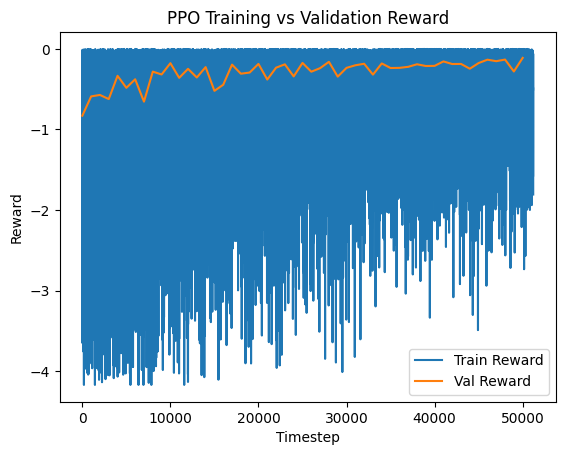

Predicción basada en reglas completa en 0.00 segundos


In [7]:
# Create the training and validation environments
train_env_ppo = InsulinDoseEnv(X_cgm_train, X_other_train, y_train, scaler_y)
val_env_ppo = InsulinDoseEnv(X_cgm_val, X_other_val, y_val, scaler_y)
callback = RewardCallback(val_env=val_env_ppo)

# Verify that the environment is correctly implemented
check_env(train_env_ppo)

# Initialize the PPO model
model_ppo = PPO("MlpPolicy", 
                train_env_ppo, 
                verbose=1, 
                learning_rate=1e-4,  # Reduced learning rate
                n_steps=2048, 
                batch_size=64, 
                clip_range=0.15, 
                ent_coef=0.01)   # Reduce entropy coefficient
# Train the model
total_timesteps = 50000  # Adjust based on convergence
model_ppo.learn(total_timesteps=total_timesteps, callback=callback)

# Plot training and validation rewards
plt.plot(callback.train_rewards, label='Train Reward')
plt.plot(np.arange(len(callback.val_rewards)) * 1000, callback.val_rewards, label='Val Reward')
plt.xlabel('Timestep')
plt.ylabel('Reward')
plt.legend()
plt.title('PPO Training vs Validation Reward')
plt.show()

# Save the model (optional)
model_ppo.save("ppo_insulin_dose")

# Function to generate predictions with PPO
def predict_with_ppo(model, X_cgm, X_other):
    """
    Genera predicciones utilizando el modelo PPO entrenado.
    
    Args:
        model (PPO): Modelo PPO entrenado
        X_cgm (np.ndarray): Datos CGM normalizados
        X_other (np.ndarray): Otras características normalizadas
        
    Returns:
        np.ndarray: Array con predicciones de dosis
    """
    predictions = []
    env = InsulinDoseEnv(X_cgm, X_other, np.zeros(len(X_cgm)), scaler_y)  # Dummy y since we only need X for prediction
    
    for i in range(len(X_cgm)):
        cgm_state = X_cgm[i].flatten()  # Shape: (24,)
        other_state = X_other[i]  # Shape: (6,)
        state = np.concatenate([cgm_state, other_state])  # Shape: (30,)
        
        action, _ = model.predict(state, deterministic=True)  # Use deterministic mode for evaluation
        predicted_dose = scaler_y.inverse_transform(action.reshape(-1, 1)).flatten()[0]
        predictions.append(predicted_dose)
    
    return np.array(predictions)

# Generate predictions on train, validation, and test sets
y_pred_ppo_train = predict_with_ppo(model_ppo, X_cgm_train, X_other_train)
y_pred_ppo_val = predict_with_ppo(model_ppo, X_cgm_val, X_other_val)
y_pred_ppo = predict_with_ppo(model_ppo, X_cgm_test, X_other_test)


# Generate rule-based predictions for comparison
y_rule = rule_based_prediction(X_other_test, scaler_other, scaler_y)

In [8]:
# Metrics for PPO
mae_ppo = mean_absolute_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_pred_ppo)
rmse_ppo = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_pred_ppo))
r2_ppo = r2_score(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_pred_ppo)
print(f"PPO Test - MAE: {mae_ppo:.2f}, RMSE: {rmse_ppo:.2f}, R²: {r2_ppo:.2f}")

# Metrics for the Rules-based model
mae_rule = mean_absolute_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_rule)
rmse_rule = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_rule))
r2_rule = r2_score(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_rule)
print(f"Rules Test - MAE: {mae_rule:.2f}, RMSE: {rmse_rule:.2f}, R²: {r2_rule:.2f}")

PPO Test - MAE: 0.24, RMSE: 0.34, R²: 0.82
Rules Test - MAE: 1.17, RMSE: 1.42, R²: -2.15


In [9]:
# Metrics for train
mae_ppo_train = mean_absolute_error(scaler_y.inverse_transform(y_train.reshape(-1, 1)), y_pred_ppo_train)
rmse_ppo_train = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_train.reshape(-1, 1)), y_pred_ppo_train))
r2_ppo_train = r2_score(scaler_y.inverse_transform(y_train.reshape(-1, 1)), y_pred_ppo_train)
print(f"PPO Train - MAE: {mae_ppo_train:.2f}, RMSE: {rmse_ppo_train:.2f}, R²: {r2_ppo_train:.2f}")

# Metrics for validation
mae_ppo_val = mean_absolute_error(scaler_y.inverse_transform(y_val.reshape(-1, 1)), y_pred_ppo_val)
rmse_ppo_val = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_val.reshape(-1, 1)), y_pred_ppo_val))
r2_ppo_val = r2_score(scaler_y.inverse_transform(y_val.reshape(-1, 1)), y_pred_ppo_val)
print(f"PPO Val - MAE: {mae_ppo_val:.2f}, RMSE: {rmse_ppo_val:.2f}, R²: {r2_ppo_val:.2f}")

# Metrics for test (already computed)
print(f"PPO Test - MAE: {mae_ppo:.2f}, RMSE: {rmse_ppo:.2f}, R²: {r2_ppo:.2f}")

PPO Train - MAE: 0.19, RMSE: 0.28, R²: 0.81
PPO Val - MAE: 0.16, RMSE: 0.24, R²: 0.83
PPO Test - MAE: 0.24, RMSE: 0.34, R²: 0.82


In [10]:
from sklearn.model_selection import KFold

def run_cv_fold(train_subs, test_subs, df_final_pd, cgm_columns, other_features):
    """
    Ejecuta un fold de validación cruzada para el modelo PPO.
    
    Args:
        train_subs (np.ndarray): IDs de sujetos para entrenamiento
        test_subs (np.ndarray): IDs de sujetos para prueba
        df_final_pd (pd.DataFrame): DataFrame con datos procesados
        cgm_columns (list): Lista de columnas CGM
        other_features (list): Lista de otras características
        
    Returns:
        float: MAE en el conjunto de prueba
    """
    train_mask = df_final_pd['subject_id'].isin(train_subs)
    test_mask = df_final_pd['subject_id'].isin(test_subs)
    
    X_cgm_train_cv = scaler_cgm.transform(df_final_pd.loc[train_mask, cgm_columns]).reshape(-1, 24, 1)
    X_other_train_cv = scaler_other.transform(df_final_pd.loc[train_mask, other_features])
    y_train_cv = scaler_y.transform(df_final_pd.loc[train_mask, 'normal'].values.reshape(-1, 1)).flatten()
    X_cgm_test_cv = scaler_cgm.transform(df_final_pd.loc[test_mask, cgm_columns]).reshape(-1, 24, 1)
    X_other_test_cv = scaler_other.transform(df_final_pd.loc[test_mask, other_features])
    y_test_cv = scaler_y.transform(df_final_pd.loc[test_mask, 'normal'].values.reshape(-1, 1)).flatten()
    
    env_cv = InsulinDoseEnv(X_cgm_train_cv, X_other_train_cv, y_train_cv, scaler_y)
    model_cv = PPO("MlpPolicy", env_cv, verbose=0, learning_rate=3e-4, n_steps=2048, batch_size=64)
    model_cv.learn(total_timesteps=50000)  # Reduced for speed
    y_pred_cv = predict_with_ppo(model_cv, X_cgm_test_cv, X_other_test_cv)
    return mean_absolute_error(scaler_y.inverse_transform(y_test_cv.reshape(-1, 1)), y_pred_cv)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
subject_ids = df_final['subject_id'].unique().to_numpy()
mae_scores = []
cgm_columns = [f'cgm_{i}' for i in range(24)]
other_features = ['carbInput', 'bgInput', 'insulinOnBoard', 'insulinCarbRatio', 
                  'insulinSensitivityFactor', 'hour_of_day']

# Convertir a pandas para KFold
df_final_pd = df_final.to_pandas()

for train_idx, test_idx in kf.split(subject_ids):
    train_subs = subject_ids[train_idx]
    test_subs = subject_ids[test_idx]
    mae_cv = run_cv_fold(train_subs, test_subs, df_final_pd, cgm_columns, other_features)
    mae_scores.append(mae_cv)

print(f"Cross-validated PPO MAE: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")

Cross-validated PPO MAE: 0.16 ± 0.02


Train y: mean = 1.2594012708074198 std = 0.6510074450870852
Val y: mean = 1.1919940470318169 std = 0.5797949034534428
Test y: mean = 1.1738024872540749 std = 0.7997420942614523


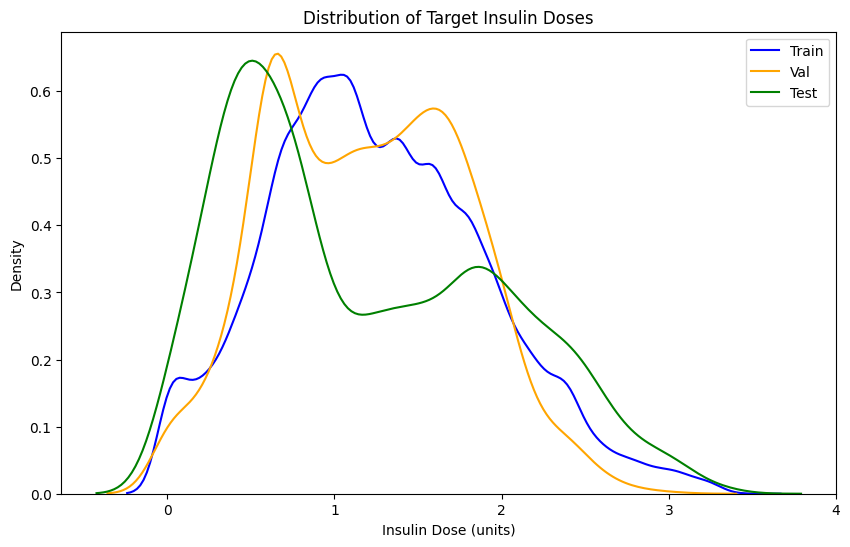

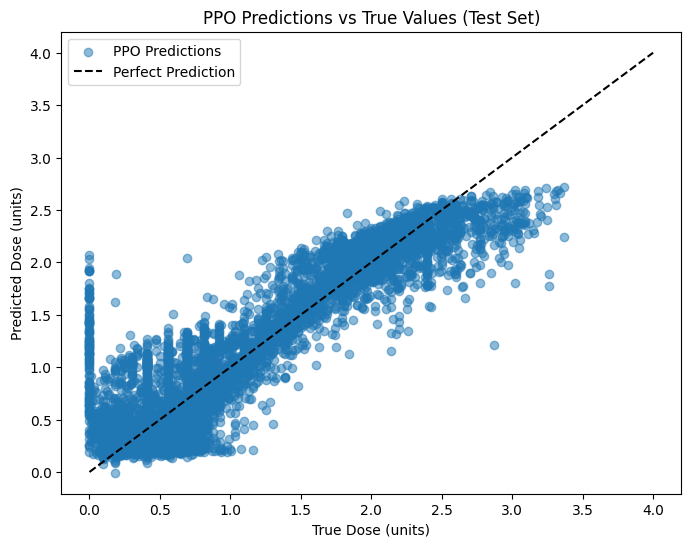

In [11]:
y_train_denorm = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_val_denorm = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_test_denorm = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

print("Train y: mean =", np.mean(y_train_denorm), "std =", np.std(y_train_denorm))
print("Val y: mean =", np.mean(y_val_denorm), "std =", np.std(y_val_denorm))
print("Test y: mean =", np.mean(y_test_denorm), "std =", np.std(y_test_denorm))

plt.figure(figsize=(10, 6))
sns.kdeplot(y_train_denorm, label='Train', color='blue')
sns.kdeplot(y_val_denorm, label='Val', color='orange')
sns.kdeplot(y_test_denorm, label='Test', color='green')
plt.xlabel('Insulin Dose (units)')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Target Insulin Doses')
plt.show()

# Plot predictions vs true values for test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test_denorm, y_pred_ppo, alpha=0.5, label='PPO Predictions')
plt.plot([0, 4], [0, 4], 'k--', label='Perfect Prediction')
plt.xlabel('True Dose (units)')
plt.ylabel('Predicted Dose (units)')
plt.legend()
plt.title('PPO Predictions vs True Values (Test Set)')
plt.show()

In [12]:
# Visualize the results


Rendimiento por sujeto (Test Set):
Sujeto 7: PPO MAE=0.27, Rules MAE=2.05
Sujeto 14: PPO MAE=0.28, Rules MAE=0.51
Sujeto 32: PPO MAE=0.16, Rules MAE=1.07
Sujeto 40: PPO MAE=0.26, Rules MAE=1.04
Sujeto 44: PPO MAE=0.18, Rules MAE=1.05
Sujeto 49: PPO MAE=0.25, Rules MAE=1.83
Subject 49 - Mean dose: 1.83, Std: 0.67


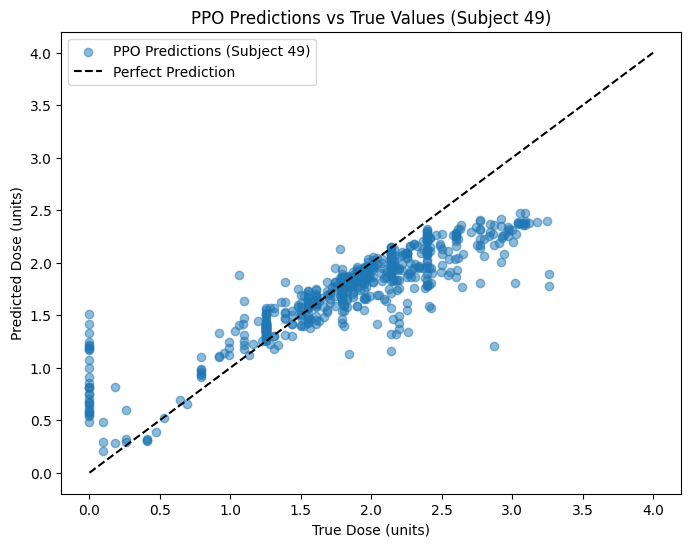

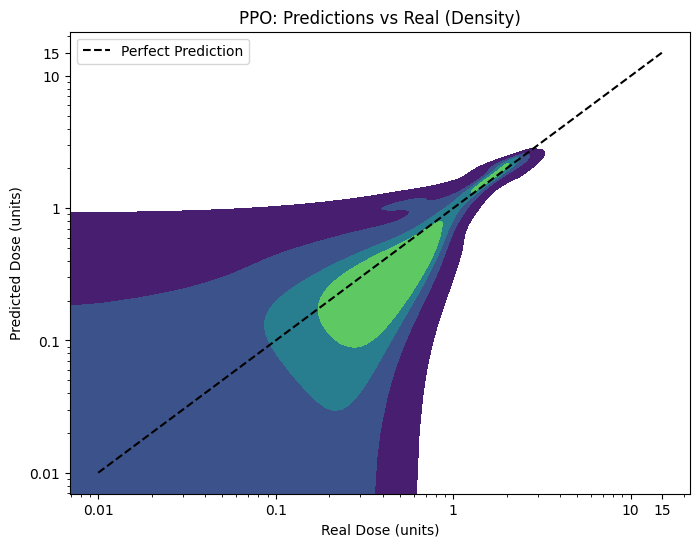

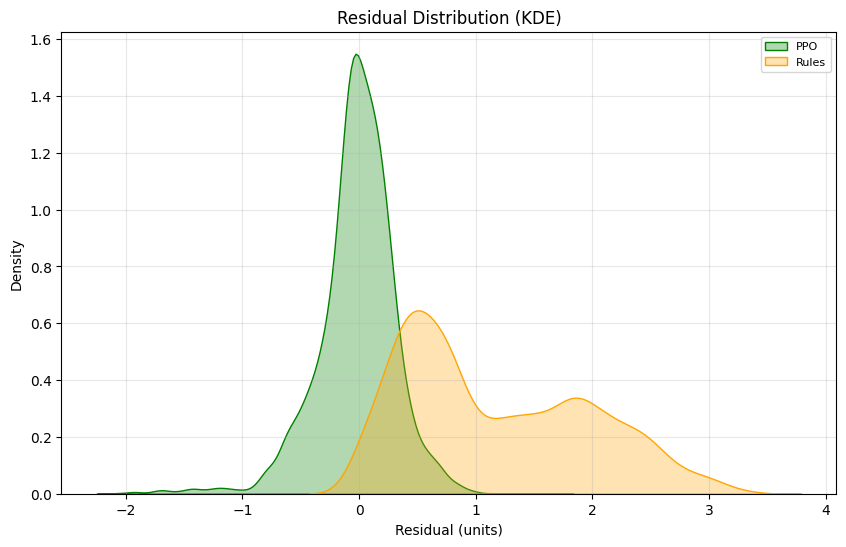

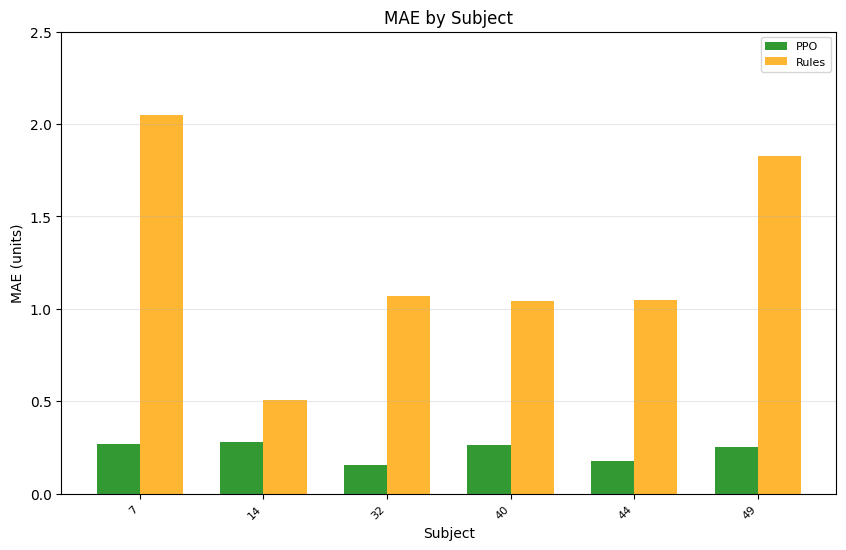

Visualización completa en 1.19 segundos


In [13]:
# Analyze performance per subject
print("\nRendimiento por sujeto (Test Set):")
for subject_id in np.unique(subject_test):
    mask = subject_test == subject_id
    if np.sum(mask) > 0:
        y_test_sub = scaler_y.inverse_transform(y_test[mask].reshape(-1, 1)).flatten()
        print(f"Sujeto {subject_id}: ", end="")
        mae_ppo_sub = mean_absolute_error(y_test_sub, y_pred_ppo[mask])
        print(f"PPO MAE={mae_ppo_sub:.2f}, ", end="")
        mae_rule_sub = mean_absolute_error(y_test_sub, y_rule[mask])
        print(f"Rules MAE={mae_rule_sub:.2f}")

# Check if subject 49 exists in test set
if 49 in np.unique(subject_test):
    mask_49 = subject_test == 49
    y_test_49 = scaler_y.inverse_transform(y_test[mask_49].reshape(-1, 1)).flatten()
    print(f"Subject 49 - Mean dose: {y_test_49.mean():.2f}, Std: {y_test_49.std():.2f}")
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_49, y_pred_ppo[mask_49], alpha=0.5, label='PPO Predictions (Subject 49)')
    plt.plot([0, 4], [0, 4], 'k--', label='Perfect Prediction')
    plt.xlabel('True Dose (units)')
    plt.ylabel('Predicted Dose (units)')
    plt.legend()
    plt.title('PPO Predictions vs True Values (Subject 49)')
    plt.show()
else:
    print("Subject 49 not found in test set")

plot_evaluation(y_test, y_pred_ppo, y_rule, subject_test, scaler_y)


Training PPO with 50000 timesteps:
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -0.969   |
| time/              |          |
|    fps             | 4652     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | -0.857      |
| time/                   |             |
|    fps                  | 3602        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.045529425 |
|    clip_fraction        | 0.25        |
|    clip_range           

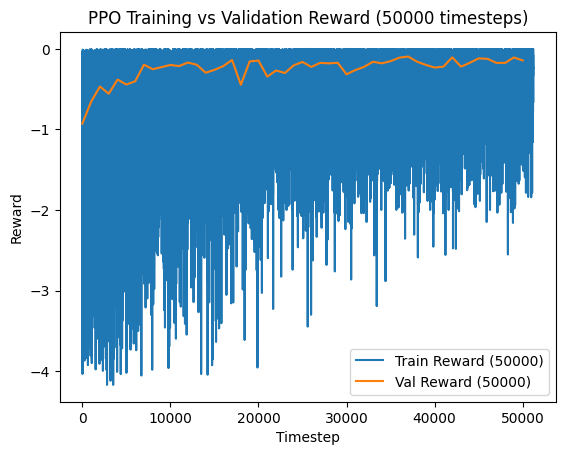


Training PPO with 200000 timesteps:
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -1.04    |
| time/              |          |
|    fps             | 3136     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | -0.865     |
| time/                   |            |
|    fps                  | 3069       |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.04451034 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2      

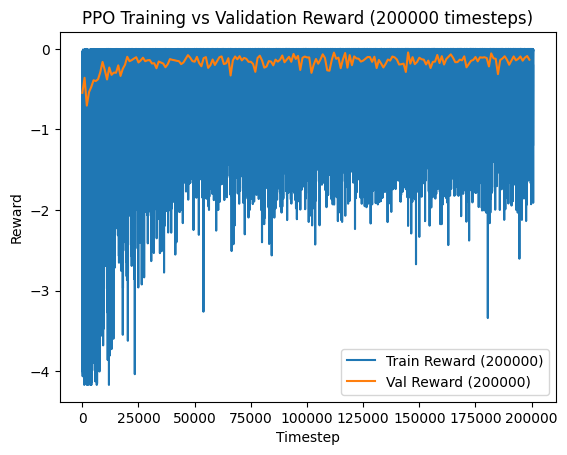

In [14]:
# %% CELL: Main Execution - Tune PPO Training (Optional)
# Test different timesteps to check convergence
for timesteps in [50000, 200000]:
    print(f"\nTraining PPO with {timesteps} timesteps:")
    model_ppo_tune = PPO("MlpPolicy", train_env_ppo, verbose=1, learning_rate=3e-4, n_steps=2048, batch_size=64)
    callback_tune = RewardCallback(val_env=val_env_ppo)
    model_ppo_tune.learn(total_timesteps=timesteps, callback=callback_tune)
    
    y_pred_ppo_test_tune = predict_with_ppo(model_ppo_tune, X_cgm_test, X_other_test)
    mae_tune = mean_absolute_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_pred_ppo_test_tune)
    rmse_tune = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_pred_ppo_test_tune))
    r2_tune = r2_score(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_pred_ppo_test_tune)
    print(f"PPO Test (tuned {timesteps}) - MAE: {mae_tune:.2f}, RMSE: {rmse_tune:.2f}, R²: {r2_tune:.2f}")
    
    plt.plot(callback_tune.train_rewards, label=f'Train Reward ({timesteps})')
    plt.plot(np.arange(len(callback_tune.val_rewards)) * 1000, callback_tune.val_rewards, label=f'Val Reward ({timesteps})')
    plt.xlabel('Timestep')
    plt.ylabel('Reward')
    plt.legend()
    plt.title(f'PPO Training vs Validation Reward ({timesteps} timesteps)')
    plt.show()